# Transfer Learning on CNN | Image Classification
### COVID Chest Infection Detection

Computer Vision is a field of artificial intelligence that enables machines the ability to "See" things. The word "See" is not what you think of it as just what a camera do, capturing moments. But thats not it, "See" means that machine can able to perceive things and understands the difference or relation between the real world physical entities. This state of "See" is we achieved now takes a lot of hard word, research and iterations. We achieved it by solving little pieces of it like Image Classification, Image Segmentation and Object Segmentation, etc. 

> We are so blessed to be born in this period, as we have a plethora of resesources and community of people to guide us through.

### Why AI in Health Care is crucial?
Though many fields can be benificial by the implementation of Artificial Intelligence, it is the field of Health Care which would be benifitted the most and in turn Humanity. It very hard to diagnose X-ray scans, and take decisions deterministically at the right momemt. There is also human errors associated with it. Computers can contribute a ton to Health and Medicine as an "SideKick" to humans(Doctors). I wouldn't say Computer can outperform with absolute percision, it may have fail in some cases. That's why we have computers to assist Doctors.

![Pneumoia Detection](https://i.imgur.com/jZqpV51.png)



I assume you may have come across this Deep Learning library that is familiar with most Data Scientists and AI Researchers. 
<img src="https://www.quintagroup.com/blog/blog-images/machine-learning-libraries/pytorch.png/@@images/cce95fa7-4048-42c1-b768-dca2a747b8bd.png" width=300 alt="PyTorch" >

## PyTorch

PyTorch is a Deep Learning library which makes Tensor Computations, a core part in Deep Learning applications. It is developed and used by Facebook AI Research Lab. It has been library which attracted many researchers and develop many State-of-the-Art Algorithms across all the fields of Deep Learning such as Computer Vision, NLP and Tabular Data Processing. 

### Why learn PyTorch?
PyTorch is home for many powerful projects and future researches in Deep Learning and Artificial Intelligence. FaceBook AI Research (FAIR) contributed an enormous amount of new mind boggling researches and projects built o PyTorch. Detectron2(CV), HugginngFace(NLP),DETR(CV) are some of amazing projects by them based on PyTorch. So you will be able to see and develop your own State-of-the-Art applications inspiring from these projects. And also PyTorch is so friendly looking with most of the code will look like vanila "Python" Structures.
> I learnt PyTorch after I got comfortable with Tensorflow/Keras. I think PyTorch has more flexibility for a coder and Customizable. I get to know the process behind the Traning of Model better with PyTorch.

## Let's get started
Ok, I can hear you say "ENOUGH". Alright, let's get started in this notebook I am gonna guide you through a image classification task using PyTorch. So the problem statement that I am gonna take will be...

# COVID-19 Detection using Chest Xray
As you probably know, we are in the tight hold of a pandemic which has its disastarous effect on this world. We are standing together even while physically distancing ourselves, protecting others and caring for others in this dreadful times. Humanity still deserved to live for million years. But we should contribute our role in this fight against an invisible enemy. 

> Many Data Scientist are working getting predictions and developing models for strategies. We can assist HealthCare workers and Doctors by developing a AI Assistment or Model. A Image Classification model can handle a lot of worries for Doctors, especially in X Ray Diagnosis.

In this notebook, I am going to train a CNN classifier which can classify COVID-19 Infected Lung Xray images from Healthy Lung Xray images. For that we need dataset from both classes, I used the dataset from two sources,

- Cohen's [COVID Chest X-ray Dataset](https://github.com/ieee8023/covid-chestxray-dataset) 
- Paul Mooney's [Chest X-ray Dataset (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

>😃 I am very grateful and thankful to the huge efforts by the Open-Source Community for collecting data in a repository. This project would be possible without those repositories.

I create the aggregate the images from those two repositories and get them ready for training. Check out the code.

In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

In [2]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 3614 (delta 7), reused 11 (delta 5), pack-reused 3599
Receiving objects: 100% (3614/3614), 633.00 MiB | 37.29 MiB/s, done.
Resolving deltas: 100% (1430/1430), done.
Checking out files: 100% (1173/1173), done.


In [3]:
df = pd.read_csv('./covid-chestxray-dataset/metadata.csv')
selected_df = df[df.finding=="Pneumonia/Viral/COVID-19"]
selected_df = selected_df[(selected_df.view == "AP") | (selected_df.view == "PA")]
selected_df.head(2)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN


In [4]:
images = selected_df.filename.values.tolist()

In [5]:
os.makedirs('./COVID19-DATASET/train/covid19')
os.makedirs('./COVID19-DATASET/train/normal')

In [6]:
COVID_PATH = './COVID19-DATASET/train/covid19'
NORMAL_PATH = './COVID19-DATASET/train/normal'

In [7]:
for image in images:
    shutil.copy(os.path.join('./covid-chestxray-dataset/images', image), os.path.join(COVID_PATH, image))

In [8]:
for image in os.listdir('../input/chest-xray-pneumonia/chest_xray/train/NORMAL')[:300]:
    shutil.copy(os.path.join('../input/chest-xray-pneumonia/chest_xray/train/NORMAL', image), os.path.join(NORMAL_PATH, image))

In [9]:
DATA_PATH = './COVID19-DATASET/train'

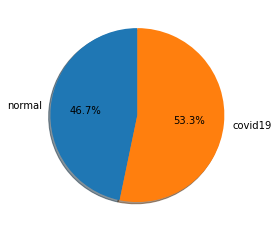

In [10]:
class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

I have taken correct propositions of data from each classes while staging my data to avoid overfitted results. Medical Image Datasets will always be like this, we don't have enough data on victim rather we have so many healthy ones. That is what we called is a "Skewed Dataset", obviously we developed methods to approach those problems (like K-Fold Cross Validation) that will explain that in my next notebook.

Lets view some images to know what we are dealing with here. Feel free the run the cell to view images at random from the repository.

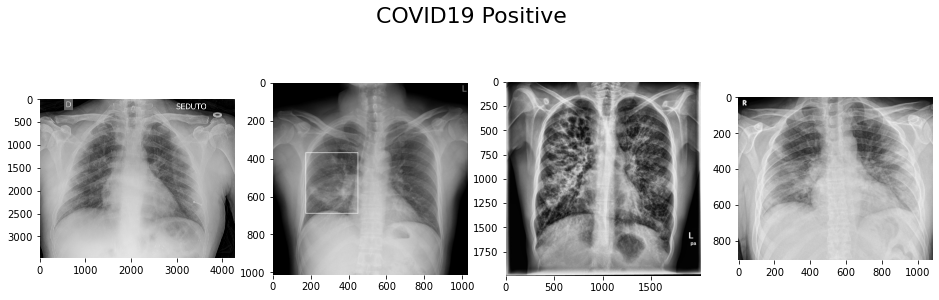

In [11]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

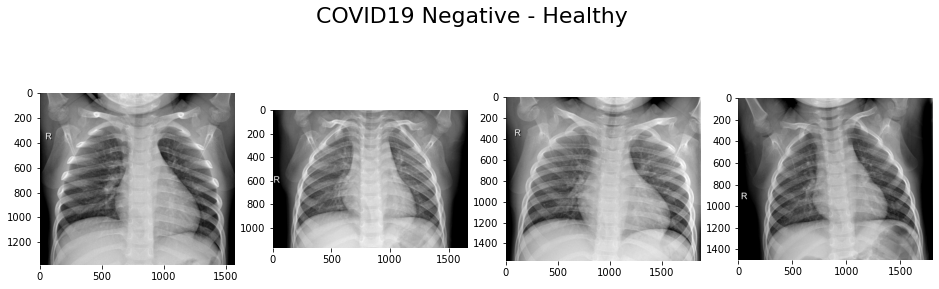

In [12]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

Have you seen how similar they look!!. Yeah right, sometimes even for a medical expert. It is hard to diagnose with Xray images. That's why we can help them with our model.

## Transforms
Data Transforms or Augmentation is the synthesis of new data using the available with some little manipulations and image processing. Augmentation will help generalizing our model, avoids Over-fitting to the training data. Since we have relatively little amounts of data for training and validation we will synthesis some extra data through Image Transforms.

<strong>torchvision</strong> from PyTorch provides,various tools that we can use to perform various tasks for Computer Vision with ease of use.

Few most used tools include,
- [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html)- Image Data Augementation
- [datasets](https://pytorch.org/docs/stable/torchvision/datasets.html)- Dataset loading and handling
- [models](https://pytorch.org/docs/stable/torchvision/models.html)- Deep Learning Pre-Defined SOTA Models

These tools will be so handy for us, so that we can concentrate on optimizing our results better.

In [13]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes all images into same dimension
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

## Train and Validation Data Split
We split our dataset into train and validation sets for training and validating our model with seperate datasets.

In [14]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)

['covid19', 'normal']


Like I said, `datasets.ImageFolder` takes the images from each folder named after the class name and automatically labels them. Then `data.DataLoader` loads those labelled images and tracks of the Train Data(Image) and Label(Class Name). Those are the X and Y value which we take for training. 

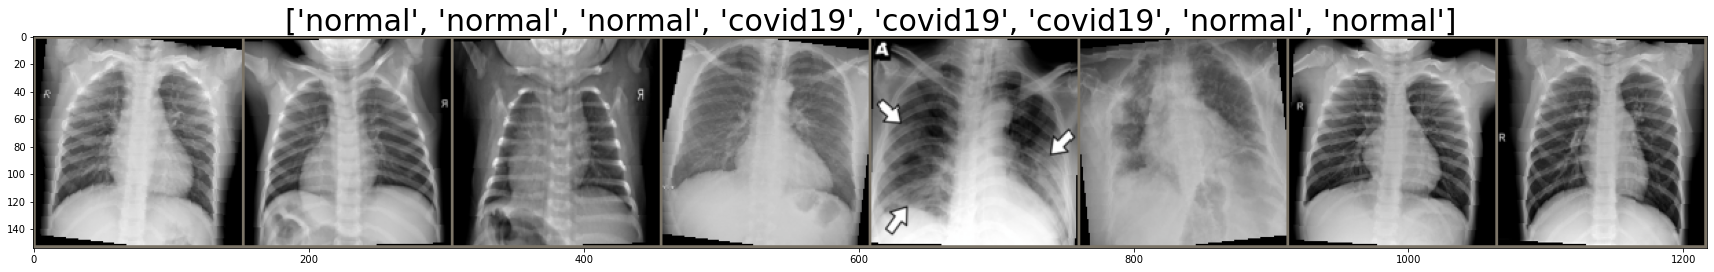

In [15]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Ofcourse, we don't want to sit for hours to see our model training. That's why we have GPU with us, now we are going to play game using GPU but this game is *The Imitation Game*

PyTorch has `device` object to load the data into the either of two hardware [CPU or CUDA(GPU)]

In [16]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [17]:
torch.cuda.empty_cache()

## Model Definition
We reached the fun part !!!. 

We use DenseNet-121 Architecture as the core here for our DL Model. We also use pre-trained weights as a means to Transfer Learning. To learn and achieve higher accuracy on our model faster.

Transfer Learning is a powerful technique that we use in Deep Learning, which is we use the model parameters which are already trained on a larger dataset (ie.ImageNet Dataset consist of 1000 Classes). For instance, its process of transfering the Knowledge of a learnt man into another. Pretrained model will already trained to extract micro features like curves and lines. We will have the previous knowledge to initalize with and we can train the model to look for what it should look.

![DenseNet-121](https://miro.medium.com/max/1400/1*vIZhPImFr9Gjpx6ZB7IOJg.png)

You can learn more about Densenets here in this [paper](https://arxiv.org/abs/1608.06993).


Here I am traning all the the Layers, instead of freezing CNN Layers and training only the Fully Connected Layer (Classification Layer) like most people do in Classification Task. Since we are handling Medical Images here we have to train the CNN layers completely or Partially.

In [18]:
def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


Since we haven't froze the CNN layer parameters untrainable, we are going to train a huge number of parameters.

In [19]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6955906


### Training
Welcome to PyTorch, here you are free to write your codes as you like with flexibility and comfortability. So shall we start writing our training code?

We are not using any wrapper class like Keras for Tensorflow, PyTorchLightning for PyTorch, we are going to write the training code ourselves from scratch. We won't regret mastering writing the Trainer code for pytorch, it would help you a ton with theoretical understanding with lavishness. 

- `model.train()` and `model.eval()` are called respectively on Training and Evaluation phase.
- Intialise Loss and Accuracy Variable of the epochs to zero
- Passing an `dataloader` object to a interative function we get Image Data and Label in batches for every loop
- Transfer the `Data` and `label` to GPU if available
- If it's Training Phase, we find Gradients and perform Back Progation for that we write the code under `torch.set_grad_enabled()` to instruct the PyTorch to consider the parameters for Backpropagation updation.
- Feed in the `Data` (X) to the `model` and it will output `outputs` (Y).
- Calculate the loss using `label` and `outputs` using criterion `nn.CrossEntropyLoss()` 
- With the loss, we can now find the gradients and perform Backprogation using `loss.backward()` and optimizer `optim.Adam()` with defined LR
- `optim.lr_scheduler.StepLR()` will update the LR based on the parameters defined.
- Find the epoch accuracy and epoch loss for both training and validation phase.
- Additionally we find validation kappa score. Kappa score is a trusted metric for evaluating Medical AI Models. You can learn more about [here](https://towardsdatascience.com/interpretation-of-kappa-values-2acd1ca7b18f)

**Note : Important step while training in PyTorch is `optimizer.zero_grad()` because PyTorch haves caches of gradients in the memory, we have to zero that out while each step.**


#### Early Stopping
Early Stopping is a method of choosing the best performed model with given conditions. Generally the conditions would be Best Validation Accuracy or Lowest Validation Loss. For this model, I choose the model with lowest validation loss for better reliable results from the model. Because more medical model is gonna diagnose a person, we dont want a false positive or false negative. 

To do that we will check for lowest validation loss at every epoch and save the model parameters weights into a object and finally load the weights to the model using `model.load_state_dict()`.

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

Let's define a function which would give image visualisations along with the predicted label to see if the model is really outputing relevant answers.

In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

I am have run with setting of 10 Epochs due to Kaggle, feel free to tweak up the no.of epochs to get even better model

In [22]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)


Epoch 1/10
----------


train Loss: 0.1779 | train Accuracy: 0.9241


val Loss: 0.0957 | val Accuracy: 0.9766 | Kappa Score: 0.9459
Val loss Decreased from inf to 0.0957 
Saving Weights... 

Epoch 2/10
----------


train Loss: 0.1253 | train Accuracy: 0.9455


val Loss: 0.0929 | val Accuracy: 0.9766 | Kappa Score: 0.9393
Val loss Decreased from 0.0957 to 0.0929 
Saving Weights... 

Epoch 3/10
----------


train Loss: 0.1512 | train Accuracy: 0.9397


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0893 | val Accuracy: 0.9766 | Kappa Score: nan
Val loss Decreased from 0.0929 to 0.0893 
Saving Weights... 

Epoch 4/10
----------


train Loss: 0.1682 | train Accuracy: 0.9319


val Loss: 0.1024 | val Accuracy: 0.9766 | Kappa Score: 0.9509

Epoch 5/10
----------


train Loss: 0.1339 | train Accuracy: 0.9416


val Loss: 0.0982 | val Accuracy: 0.9766 | Kappa Score: 0.9509

Epoch 6/10
----------


train Loss: 0.1849 | train Accuracy: 0.9358


val Loss: 0.0930 | val Accuracy: 0.9766 | Kappa Score: 0.9509

Epoch 7/10
----------


train Loss: 0.2018 | train Accuracy: 0.9222


val Loss: 0.0933 | val Accuracy: 0.9766 | Kappa Score: 0.9531

Epoch 8/10
----------


train Loss: 0.2079 | train Accuracy: 0.9280


val Loss: 0.0952 | val Accuracy: 0.9766 | Kappa Score: 0.9531

Epoch 9/10
----------


train Loss: 0.1978 | train Accuracy: 0.9300


val Loss: 0.1004 | val Accuracy: 0.9766 | Kappa Score: 0.9040

Epoch 10/10
----------


train Loss: 0.1696 | train Accuracy: 0.9436


val Loss: 0.0934 | val Accuracy: 0.9766 | Kappa Score: 0.9509

Training complete in 8m 30s
Best val loss: 0.0893


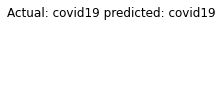

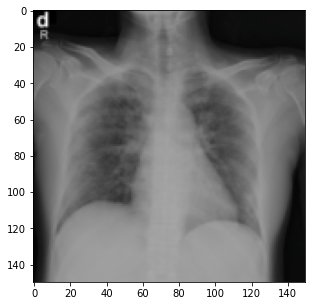

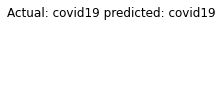

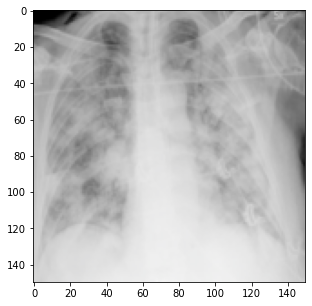

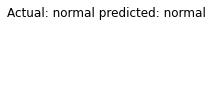

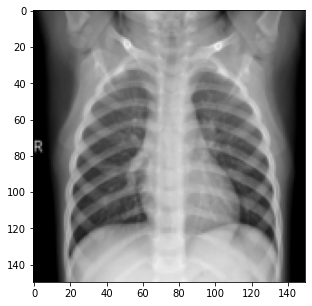

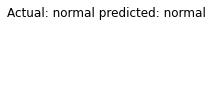

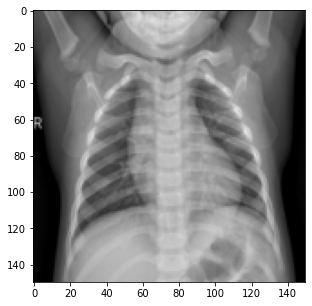

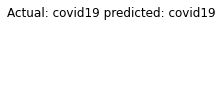

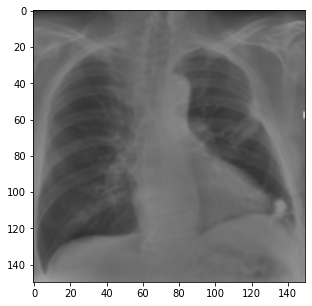

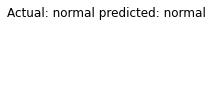

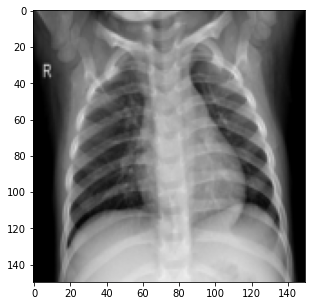

In [23]:
visualize_model(base_model)
plt.show()

## Model Evaluation
That's it, we have trained our model with great accuracy and minimum validation loss, that means it should do well with the images, it haven't seen. So we test the model with images it haven't seen before. This process is called Model Evaluation.

I use a dataset collected and published in Kaggle by @Tawsifur Rahman - [COVID-19 Radiography Database](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)

In [24]:
os.makedirs('./COVID19-DATASET/test/covid19')
os.makedirs('./COVID19-DATASET/test/normal')

I take 100 Images from each class for testing from his repository.

In [25]:
COVID_TEST = '../input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19'
NORMAL_TEST = '../input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL'

for image in os.listdir(COVID_TEST)[:100]:
    shutil.copy(os.path.join(COVID_TEST, image), os.path.join('./COVID19-DATASET/test/covid19', image))
for image in os.listdir(NORMAL_TEST)[:100]:
    shutil.copy(os.path.join(NORMAL_TEST, image), os.path.join('./COVID19-DATASET/test/normal', image))

In [26]:
TEST_DATA_PATH = './COVID19-DATASET/test/'

test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [30]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [31]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [32]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       100
           1       0.96      0.96      0.96       100

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



In [33]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

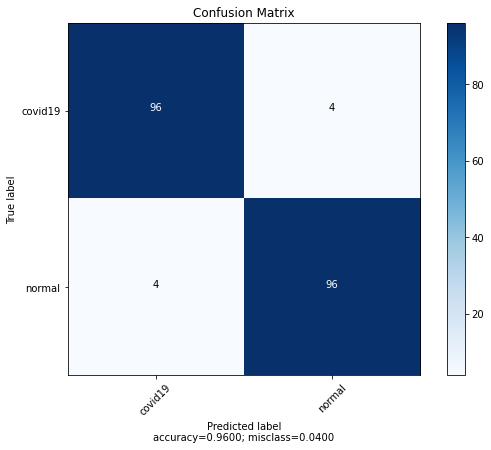

In [34]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [35]:
torch.save(base_model.state_dict(), './best_model.pth')

## Inference 
Now that you trained and tested your model, you gotta a very good model on your hand. Now we can take this to production with inference code.

An inference code is the one which is used to predict a single input image so that it can be integrated into an web app or smartphone application. Usually the inferences are done in CPU because of the hardware constraints in deployment.

In [36]:
# Loading the model pre-trained weights from saved file
inf_model = CNN_Model(pretrained=False)
inf_model.to(torch.device('cpu'))
inf_model.load_state_dict(torch.load('./best_model.pth', map_location='cpu'))
inf_model.eval()
print('Inference Model Loaded on CPU')

Inference Model Loaded on CPU


In [37]:
import cv2
from torch.autograd import Variable

In [38]:
#Inference function


def predict(img_path):
    image = Image.open(img_path)
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    # print(input.shape)
    input = input.to(torch.device('cpu'))
    out = inf_model(input)
    _, preds = torch.max(out, 1)
    idx = preds.cpu().numpy()[0]
    pred_class = class_names[idx]
    score = out[0][0].item()
    plt.imshow(np.array(image))
    print("Predicted: {}".format(pred_class))

Predicted: covid19


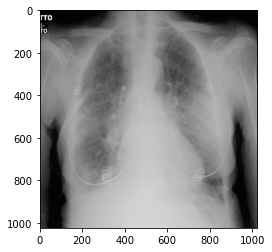

In [45]:
predict('./COVID19-DATASET/test/covid19/COVID-19(218).png') #Sample Image Path

Hurrah! Let's celebrate our victory over creating a AI which can help us diagnose CoronaVirus Patients. 

> ⚠️ But I would never claim this model to diagnose actual Patients just yet. Since we have trained this model on a very small data. We can never make assumptions or claim the model is the new Baseline Performer and it is ready to deploy for diagnosis in real world. Unless you are a Medical Expert and get the Medical Council of your country approve this. You are not allowed to proclaim your model as potential diagnosis tool.

I wrote this notebook to give a glimpse over the Image Classification using Deep Learning in PyTorch. I hope you have learnt something from this notebook. Best wishes on your future journey of Creating AI.

I would love to suggest you some resources to learn more about this incredible field.
- deeplearning.ai's courses on [Convolutional Neural Network](https://www.coursera.org/learn/convolutional-neural-networks) and [AI on Medicine](https://www.deeplearning.ai/ai-for-medicine/)
- PyTorch [Tutorials](https://pytorch.org/tutorials/) some of them are very intriguing 
- MLMED Chester Xray Diagnosis Assistant on [Github](https://github.com/mlmed/dl-web-xray)

### Author : [Arun Pandian R](https://arunpandian.me)